# Areal Interpolation of Population Counts Using National Land Cover Data (NLCD) in Python: vectorized raster


This is a notebook that presents the functions built that uses the US Geological Survey's National Land Cover Data (NLCD) for population interpolation. This comprises a concise framework to use the NLCD data to estimate population into any spatial extent that the researcher might be interested. This step-by-step procedure can be used, for example, to more accurately harmonize population between two distinct periods of time that might have different spatial extents. For exemple, two different set of census tracts.

This was inpired by *Reibel, Michael, and Aditya Agrawal. "Areal interpolation of population counts using pre-classified land cover data." Population Research and Policy Review 26.5-6 (2007): 619-633.*

First let's import all the functions that we want:

In [1]:
from tobler.vectorized_raster_interpolation import *

# Step 1: read the corresponding image

The first step to use these functionalities is to read a file from NLCD. We chose to use the data from Pennsylvania state like in example of the [GeoPySpark homepage](https://github.com/locationtech-labs/geopysparkk) and then download the file with these commands:

```
curl -o /tmp/NLCD2011_LC_Pennsylvania.zip "https://s3-us-west-2.amazonaws.com/prd-tnm/StagedProducts/NLCD/data/2011/landcover/states/NLCD2011_LC_Pennsylvania.zip?ORIG=513_SBDDG"

unzip -d /tmp /tmp/NLCD2011_LC_Pennsylvania.zip

```
Then in the same directory as this notebook do
```
ln -s /tmp/NLCD2011_LC_Pennsylvania.tif .
```

Now, you need to specify the file path of the unzipped file that would look like something like this:

In [2]:
filepath = 'C:\\Users\\renan\\Desktop\\scan_line_JAVA\\NLCD2011_LC_Pennsylvania.tif'
#filepath = '~/NLCD2011_LC_Pennsylvania.tif'

Now, we import most of the needed packages to run the following steps. We highlight the rasterio package that is used to read and process the image of Pennsylvania.

In [3]:
%matplotlib inline
import rasterio
from rasterio.plot import show

import pandas as pd
import pickle

import geopandas as gpd

import statsmodels.formula.api as smf
from statsmodels.genmod.families import Poisson

import numpy as np

import time

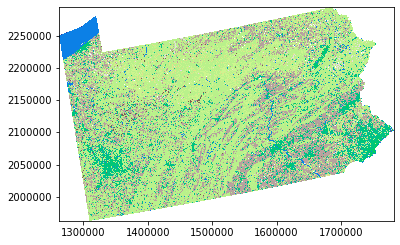

In [4]:
penn_raster = rasterio.open(filepath)
show(penn_raster, cmap='terrain')

Each pixel represent one classification according to the NLCD. Therefore, we need to build a correspondence of the pixels code and what they represent accordingly to https://www.mrlc.gov/sites/default/files/metadata/landcover.html.

Another nice way to explore the NLCD is to use this Explorer Tool: https://www.mrlc.gov/viewer/

The description of the codes follows below:

In [5]:
with open('../files/land_cover_corresp.pkl', 'rb') as input:
    land_cover_corresp = pickle.load(input)
land_cover_corresp

,Code,Long_Description,Short_Description
0,11,"Open Water - All areas of open water, generall...",Open Water
1,12,Perennial Ice/Snow - All areas characterized b...,Perennial Ice/Snow
2,21,"Developed, Open Space - Includes areas with a ...","Developed, Open Space"
3,22,"Developed, Low Intensity -Includes areas with ...","Developed, Low Intensity"
4,23,"Developed, Medium Intensity - Includes areas w...","Developed, Medium Intensity"
5,24,"Developed, High Intensity - Includes highly de...","Developed, High Intensity"
6,31,Barren Land (Rock/Sand/Clay) - Barren areas of...,Barren Land (Rock/Sand/Clay)
7,41,Deciduous Forest - Areas dominated by trees ge...,Deciduous Forest
8,42,Evergreen Forest - Areas dominated by trees ge...,Evergreen Forest
9,43,Mixed Forest - Areas dominated by trees genera...,Mixed Forest


# Step 2: read a GeoDataFrame and append population from external source

So far, we only read the image data from the NLCD, but not with any polygons from any spatial context of interest yet. This example uses all census data that the user must provide your own copy of the external database. A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/geosnap/tree/master/geosnap/data. After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.

*obs.: this step could be from any shapefile, GeoJson, etc. that the researcher might have*

In [6]:
filepath = 'C:\\Users\\renan\\Desktop\\osnap_data\\LTDB_Std_All_fullcount\\LTDB_Std_2010_fullcount.csv'
#filepath = '~/data/LTDB_Std_2010_fullcount.csv'

census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")

# This file can be download here: https://drive.google.com/open?id=1gWF0OCn6xuR_WrEj7Ot2jY6KI2t6taIm
with open('C:\\Users\\renan\\Desktop\\scan_line_JAVA\\tracts_US.pkl', 'rb') as input:
#with open('../files/tracts_US.pkl', 'rb') as input:
    map_gpd = pickle.load(input)

df = census_2010.loc[(census_2010.state == "PA")]

map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
merged_gdf = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'tractid')
merged_gdf.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,COUNTY_ID,county_id2,COUNTYNS10,NAME10_COU,GEOID_MSA,...,a15hsp10,a60hsp10,ageasn10,a15asn10,a60asn10,agentv10,a15ntv10,a60ntv10,GlobD10,GlobG10
0,42,001,030800,42001030800,308,42001,42001,1213656,Adams,23900,...,132,14,60,14,5,6,1,2,w,White
1,42,001,030400,42001030400,304,42001,42001,1213656,Adams,23900,...,164,24,23,7,0,11,1,2,wh,Single immig
2,42,001,030300,42001030300,303,42001,42001,1213656,Adams,23900,...,204,15,11,4,1,15,5,2,wh,Single immig
3,42,001,030500,42001030500,305,42001,42001,1213656,Adams,23900,...,155,18,8,1,2,4,0,2,wh,Single immig
4,42,001,030700,42001030700,307,42001,42001,1213656,Adams,23900,...,167,19,42,6,7,3,0,1,w,White


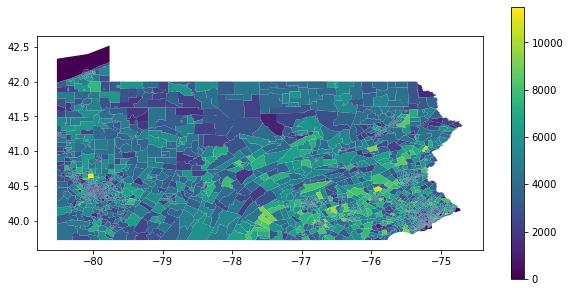

In [7]:
merged_gdf.plot(column = 'pop10', legend = True, figsize = (10, 5))

# Step 3: create weights from regression for each pixel type

Once you've got your GeoDataFrame with the desired variable, which is the total population in this case, already created and also the raster from NLCD data, you can estimate the weight of each are type according to the code and code description with the function `return_weights_from_regression`. In this function, you'll estimate the following model, by default:

\begin{equation}
\begin{split}
Population_i & \sim Poisson(\mu_i)\\
log(\mu_i) & = \beta_1 \times Type\_21_i + \beta_2 \times Type\_22_i + \beta_3 \times Type\_23_i + \beta_4 \times Type\_24_i\
\end{split}
\end{equation}

*obs.: please, note that this regression is without intercept.*

For a more detailed information and alternative options of this function you can type `help(return_weights_from_regression)`:

In [8]:
help(return_weights_from_regression)

Help on function return_weights_from_regression in module tobler.vectorized_raster_interpolation:

return_weights_from_regression(geodataframe, raster, pop_string, codes=[21, 22, 23, 24], likelihood='Poisson', n_pixels_option_values=256, force_crs_match=True, na_value=255, ReLU=True)
    Function that returns the weights of each land type according to NLCD types/codes
    
    Parameters
    ----------
    
    geodataframe           : a geopandas geoDataFrame used to build regression
    
    raster                 : a raster (from rasterio.open) that has the types of each pixel in the geodataframe
    
    pop_string             : the name of the variable on geodataframe that the regression shall be conducted
    
    codes                  : an integer list of codes values that should be considered as 'populated' from the National Land Cover Database (NLCD).
                             The description of each code can be found here: https://www.mrlc.gov/sites/default/files/metadata

In [9]:
weights = return_weights_from_regression(merged_gdf, penn_raster, 'pop10')
weights

Appending profile...
Append profile: Done.appended out of 3218
Starting to fit regression...


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00010691, 0.00097775, 0.00281514, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

The resulting vector is a vector the coefficients of the regresison in the exact positions of the code of each land type. This is going to be needed for the future interpolation. 

Since several things happen under the hood of the `return_weights_from_regression` function, we choose to explain in more details this step in a separate example notebook called `vectorized_raster_weights_from_regression_explained_example`.

*One alternative way to calculate weights is to use the approach of the function `return_weights_from_xgboost`, instead of the regression approach.*

# Step 4: create correspondence table for each pixel

This step might be one of the most expensive, computationally, in this process with the function `create_non_zero_population_by_pixels_locations`. Therefore, we inform the calculated total time. 

In this function, you create a table that relates each pixel to its correspoding population. Each pixel has speciffically and uniquely one latitude and one longitude. This function internally, uses the weights given by the regression previously fitted and corrects with a correction term that varies with each tract accordingly to this equation:

$$G_S=G_W\left ( \frac{T_G}{\hat{T_G}} \right )$$

where $G_S$ is the scaled population estimate of grid cell $G$, $G_W$ is the raw weighted population estimate of grid cell $G$, $T_G$ is the observed population of the source tract of grid cell $G$, and $\hat{T_G}$ is the fitted population of the source tract of grid cell $G$ derived by applying the weights to all grid cells and summing across all grid cells in source tract $T$. For more information you can type `help(create_non_zero_population_by_pixels_locations)`.

obs. 1: Internally, all the necessary projections that might be needed are made inside the function.

obs. 2: The results are only from the pixel that have some population on it.

In [10]:
t0 = time.time()
correspondence_table = create_non_zero_population_by_pixels_locations(merged_gdf, penn_raster, 'pop10', weights)
t1 = time.time()

In [11]:
print('Total Time to build the correspondence table (in minutes): {}'.format((t1 - t0)/60))

Total Time to build the correspondence table (in minutes): 16.562226096789043


In [12]:
correspondence_table.head()

,pop_value,lons,lats
0,1.088651,1600275,2041275
1,0.119032,1599855,2041245
2,0.119032,1599885,2041245
3,0.119032,1599915,2041245
4,0.119032,1599945,2041245


As you can see, this is a table that has each pixel latitude and longitude and the corresponding population calculated in the `pop_value` variable.

Also, one characteristic is that the total value of this correspondence table is the same of the original data:

In [13]:
correspondence_table['pop_value'].sum() # Theoretically, the value is an integer, however this might not be the case due to numerical approximations

12702379.000000011

In [14]:
merged_gdf['pop10'].sum()

12702379

However, this table has over 20 million lines, since it is all the non-zero pixels of the spatial extent:

In [15]:
len(correspondence_table)

20029531

# Step 5: calculate population from a different tract subdivision

Now that we have a table that has the estimation of how many people leave in each pixel in this year, you can use this to estimate the population of basically **any clipping** that you may have in your data. Let's artificially clip the Pennsylvania State in a different set of tracts and then calculate the population for these tracts:

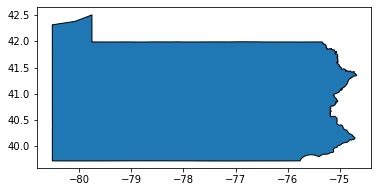

In [16]:
from shapely.ops import cascaded_union
boundary = gpd.GeoSeries(cascaded_union(merged_gdf.geometry)).buffer(0.001) # The 'buffer' method prevents some unusual points inside the state
pa_region_pre = gpd.GeoDataFrame(gpd.GeoSeries(boundary))
pa_region = pa_region_pre.rename(columns={0:'geometry'}).set_geometry('geometry')
pa_region.plot(edgecolor = 'black')

First, let's create a grid around the Pennsylvania area in order to overlay it to the actual region of this state later.

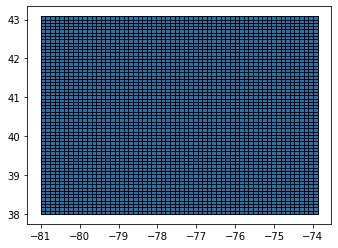

In [17]:
from shapely.geometry import Polygon

low_left  = -81
low_right = -74
up_left = 38
up_right = 43

thickness = 60

# This snippet was inspired in https://github.com/pysal/libpysal/blob/aa7882e7877b962f4269ea86a612dfc58152e5c6/libpysal/weights/user.py#L95
aux = list()
for i in np.linspace(low_left, low_right, num = thickness):
        for j in np.linspace(up_left, up_right, num = thickness):
            
            # Each width 'jump' must be at the same order of the grid constructed
            ll = i, j
            ul = i, j + np.diff(np.linspace(up_left, up_right, num = thickness))[0]
            ur = i + np.diff(np.linspace(low_left, low_right, num = thickness))[0], j + np.diff(np.linspace(up_left, up_right, num = thickness))[0]
            lr = i + np.diff(np.linspace(low_left, low_right, num = thickness))[0], j
            aux.append(Polygon([ll, ul, ur, lr, ll]))
            
polys2 = gpd.GeoSeries(aux)

envgdf = gpd.GeoDataFrame(polys2)
envgdf_final = envgdf.rename(columns={0:'geometry'}).set_geometry('geometry')
envgdf_final.plot(edgecolor = 'black')

Now, we overlay the grid built with Pennsylvania and extract the intersection.

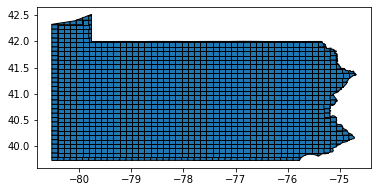

In [18]:
res_union = gpd.overlay(pa_region, envgdf_final, how='intersection')
res_union.plot(edgecolor = 'black')

Now, a very important step to take is to establish what is the Coordinate Reference System (CRS) of the GeoDataFrame we are working on. Therefore, we set that the resulting tracts of this overlay are in the same CRS of the original Pennsylvania GeoDataFrame:

ps.: this step is necessary in this case, since the resulting `res_union` does not have a CRS. 

In [19]:
res_union.crs = merged_gdf.crs
res_union.crs

{'init': 'epsg:4326'}

Now, we use the function `calculate_interpolated_population_from_correspondence_table` that uses as input the GeoDataFrame with the desired tract division, the raster file and the correspondence table built previously.

This step might be expensive computationally. Therefore, we calculate the time taken again.

In [20]:
t0 = time.time()
interpolated_pa = calculate_interpolated_population_from_correspondence_table(res_union, penn_raster, correspondence_table)
t1 = time.time()

In [21]:
print('Total Time to interpolate the population with new tracts (in minutes): {}'.format((t1 - t0)/60))

Total Time to interpolate the population with new tracts (in minutes): 73.43648063739141


In [22]:
interpolated_pa.head()

,geometry,interpolated_population
0,POLYGON ((-75.19416491077428 40.71186440677966...,67840.644085
1,"POLYGON ((-75.42372881355932 40.6271186440678,...",68971.075362
2,"POLYGON ((-75.1864406779661 40.68088509831123,...",296.431389
3,(POLYGON ((-75.10228899895466 40.7966101694915...,1543.778603
4,POLYGON ((-75.42372881355932 40.71186440677966...,22361.766555


As you can see, the result is also a GeoDataFrame with the variable called `interpolated_population`.

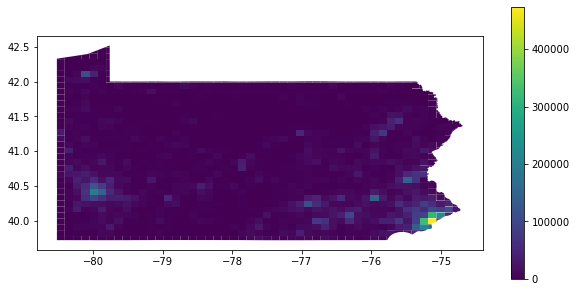

In [23]:
interpolated_pa.plot(column = 'interpolated_population', legend = True, figsize = (10, 5))

You can see the highlighted area of Philadelphia and Pittsburgh and the legend ranging from higher values than the previous map of this state. Nevertheless, we can check that the resulting total population was the same as the original data.

In [24]:
interpolated_pa['interpolated_population'].sum()

12702379.0